Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [42]:
#import libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# mount google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

A dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
#Train datset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="training",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
#Validation Dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="validation",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
#All the classes of skin cancer.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

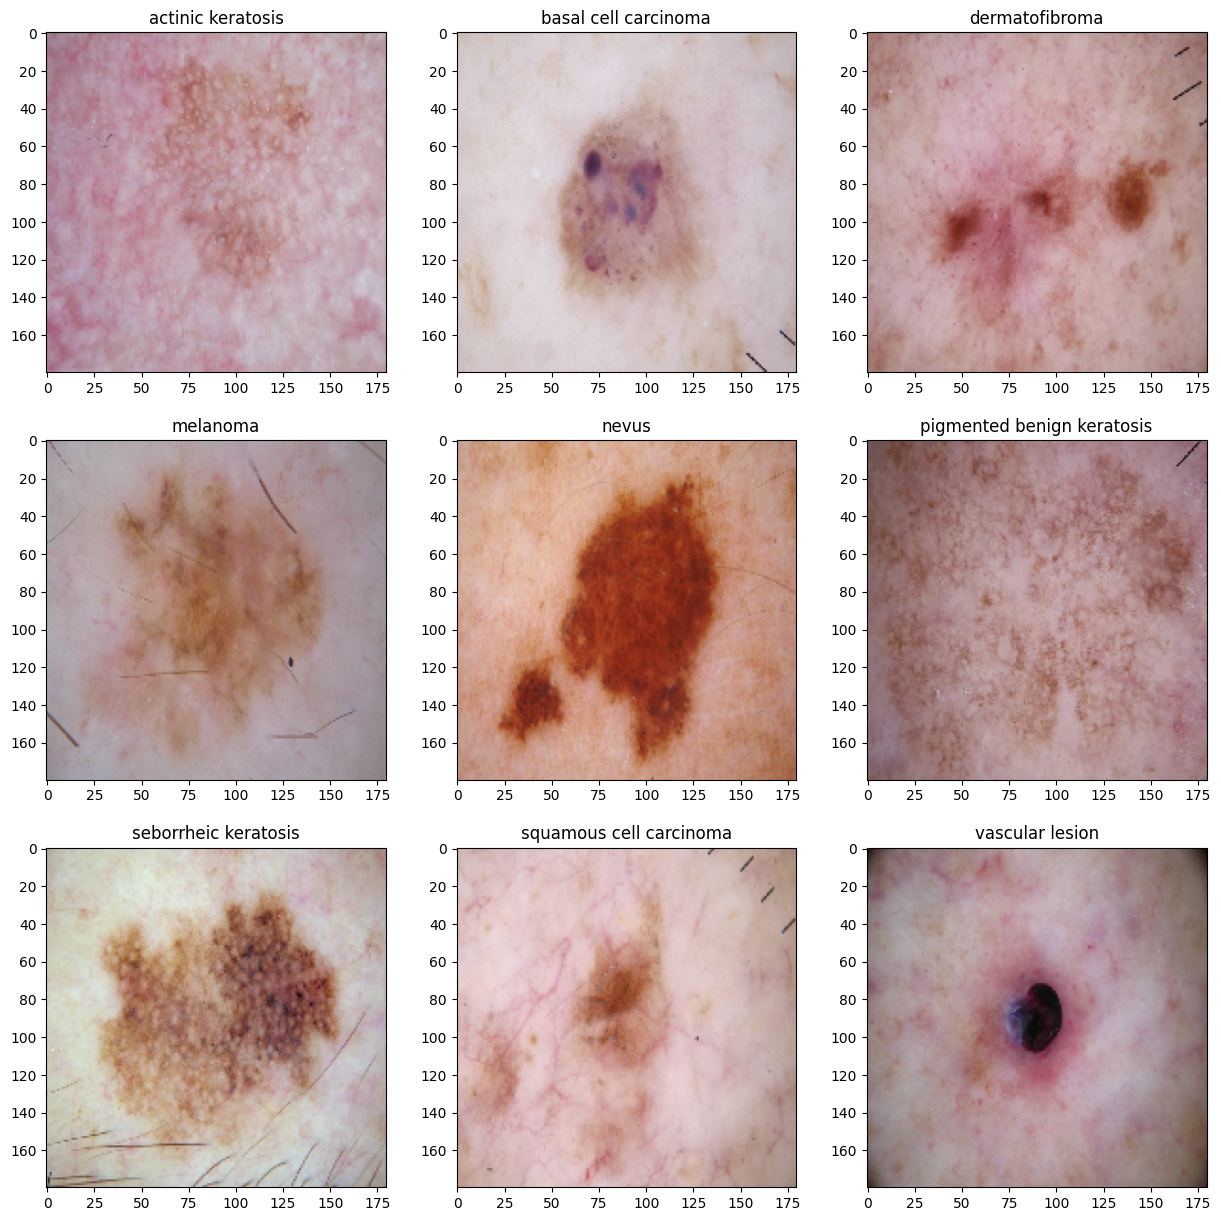

In [ ]:

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(c)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Creation

In [ ]:
input_shape = (img_height,img_width,3)

model = Sequential()    #Sequential allows you to create models layer-by-layer

#First Convulation Layer
# Changed line: Using tf.keras.layers.Rescaling instead of layers.experimental.preprocessing.Rescaling
model.add(tf.keras.layers.Rescaling(1./255, input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())   #Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.

#Dense Layer
model.add(layers.Dense(512,activation='relu'))

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model


In [ ]:

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
# summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,374,985 (100.61 MB)

 Trainable params: 26,374,985 (100.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.2203 - loss: 2.0810 - val_accuracy: 0.3960 - val_loss: 1.6732
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3769 - loss: 1.6793 - val_accuracy: 0.4631 - val_loss: 1.5288
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4963 - loss: 1.4573 - val_accuracy: 0.5257 - val_loss: 1.3906
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5273 - loss: 1.3810 - val_accuracy: 0.5123 - val_loss: 1.4554
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5359 - loss: 1.3230 - val_accuracy: 0.5347 - val_loss: 1.3452
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5703 - loss: 1.2154 - val_accuracy: 0.5257 - val_loss: 1.3381
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5792 - loss: 1.1577 - val_accuracy: 0.5101 - val_loss: 1.4124
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6274 - loss: 1.0584 - val_accuracy: 0.5257 -

### Visualizing training results

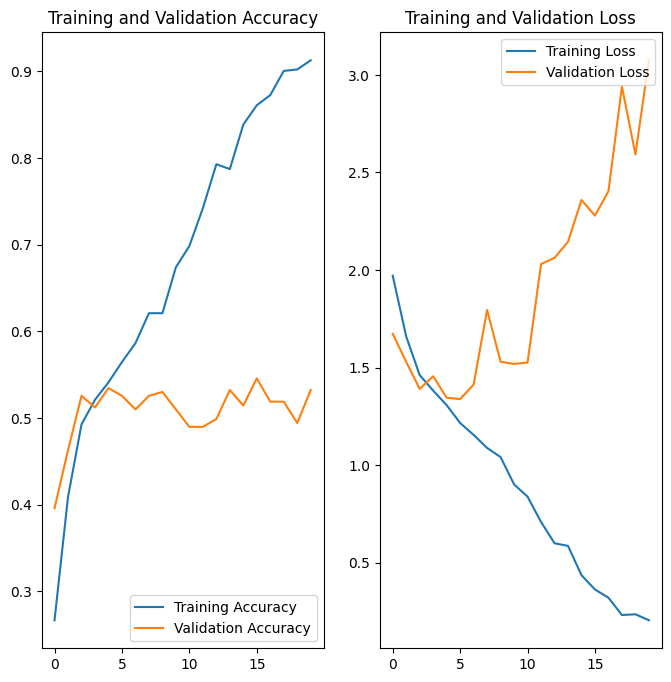

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Model is overfitting.
From the above Training vs Validation accuracy graph we can see that as the epoch increases the difference between Training accuracy and validation accuracy increases.

In [43]:
#Data augumentation strategy.

rescale = tf.keras.Sequential([
  #To rescale an input in the [0, 255] range to be in the [0, 1] range
  tf.keras.layers.Rescaling(1./255)  # Updated: Removed 'experimental.preprocessing'
])

data_augmentation = tf.keras.Sequential([
  #Randomly flip each image horizontally and vertically.
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Updated: Removed 'experimental.preprocessing'

  #Randomly rotate each image.
  tf.keras.layers.RandomRotation(0.2),  # Updated: Removed 'experimental.preprocessing'

  #Randomly zoom each image during training.
  tf.keras.layers.RandomZoom(0.2),  # Updated: Removed 'experimental.preprocessing'

  #Randomly translate each image during training.
  tf.keras.layers.RandomTranslation(0.1, 0.1)  # Updated: Removed 'experimental.preprocessing'
])

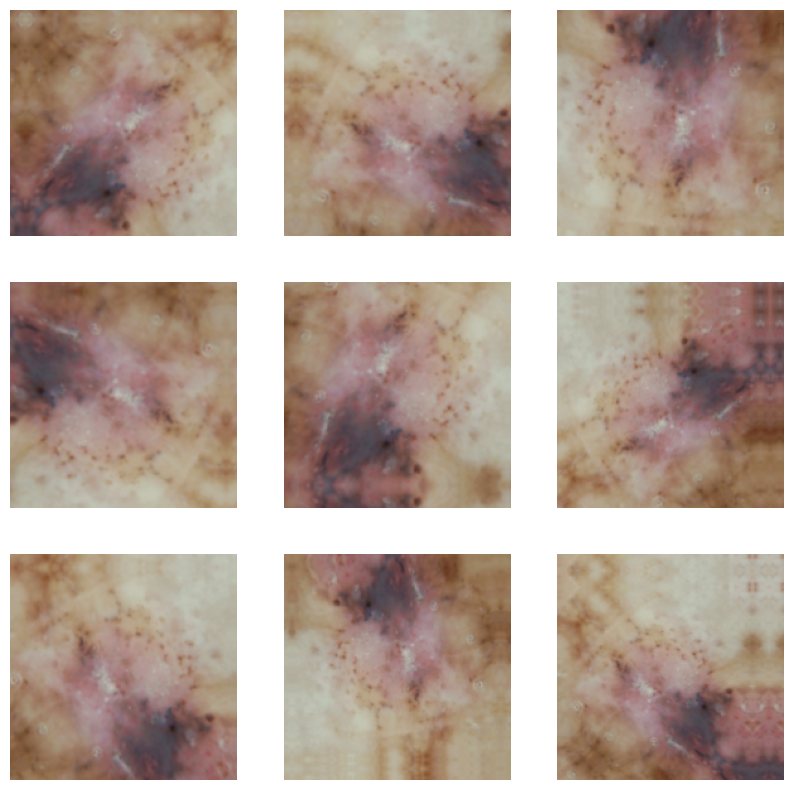

In [44]:

#Visualize the augmentation image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [45]:
## Model 2 Creation

#Dropout layer: randomly sets input units to 0 with a frequency of rate at each step during training time,
#which helps prevent overfitting.Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.


## Your code goes here
model2 = Sequential()                     #Sequential allows you to create models layer-by-layer

model2.add(data_augmentation)             #Augmentation layer
model2.add(rescale)                       #Rescaling layer

#First Convulation Layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model2.add(layers.Flatten())

#Dense Layer
model2.add(layers.Dense(512,activation='relu'))

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.50))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names),activation='softmax'))

### Compiling the model

In [46]:

model2.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

### Training the model

In [47]:


epochs =20
history = model2.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)


Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 153ms/step - accuracy: 0.1419 - loss: 2.7825 - val_accuracy: 0.2472 - val_loss: 1.9752
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.2772 - loss: 1.8643 - val_accuracy: 0.3756 - val_loss: 1.6579
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - accuracy: 0.3701 - loss: 1.6685 - val_accuracy: 0.3972 - val_loss: 1.6048
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 24s 143ms/step - accuracy: 0.3946 - loss: 1.5643 - val_accuracy: 0.4336 - val_loss: 1.4960
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 173ms/step - accuracy: 0.4202 - loss: 1.5315 - val_accuracy: 0.4499 - val_loss: 1.4664
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step - accuracy: 0.4365 - loss: 1.4745 - val_accuracy: 0.4024 - val_loss: 1.5084
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - accuracy: 0.4371 - loss: 1.4579 - val_accuracy: 0.4380 - val_loss: 1.4994
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 151ms/step - accuracy: 0.4627 - loss: 1

### Visualizing the results

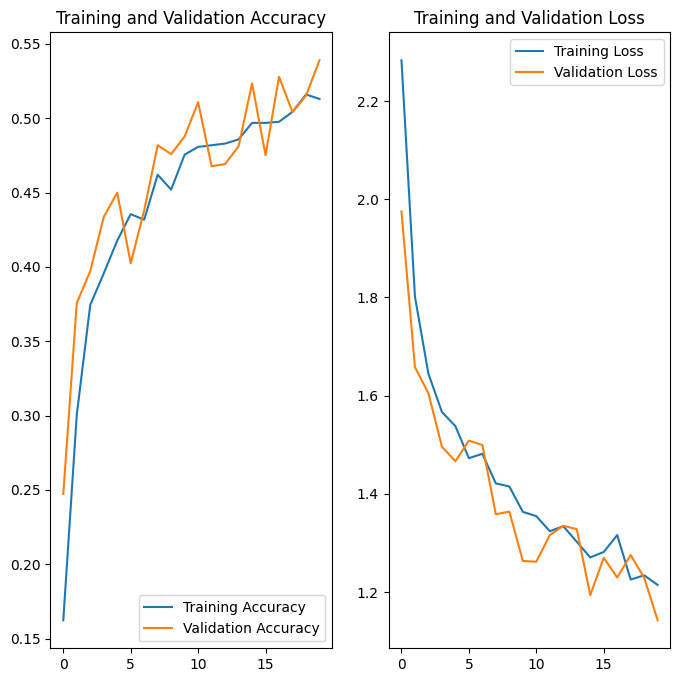

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



- After using data augumentation and dropout layer overfitting issue is reduce.

- Model Performance is still not increased. Will check the distribution of classes in the training set to check is there have class imbalance.

### Class Imbalance Detection

In [49]:

def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,nevus,357
1,actinic keratosis,114
2,dermatofibroma,95
3,seborrheic keratosis,77
4,pigmented benign keratosis,462
5,vascular lesion,139
6,basal cell carcinoma,376
7,squamous cell carcinoma,181
8,melanoma,438


<Axes: xlabel='No. of Image', ylabel='Class'>

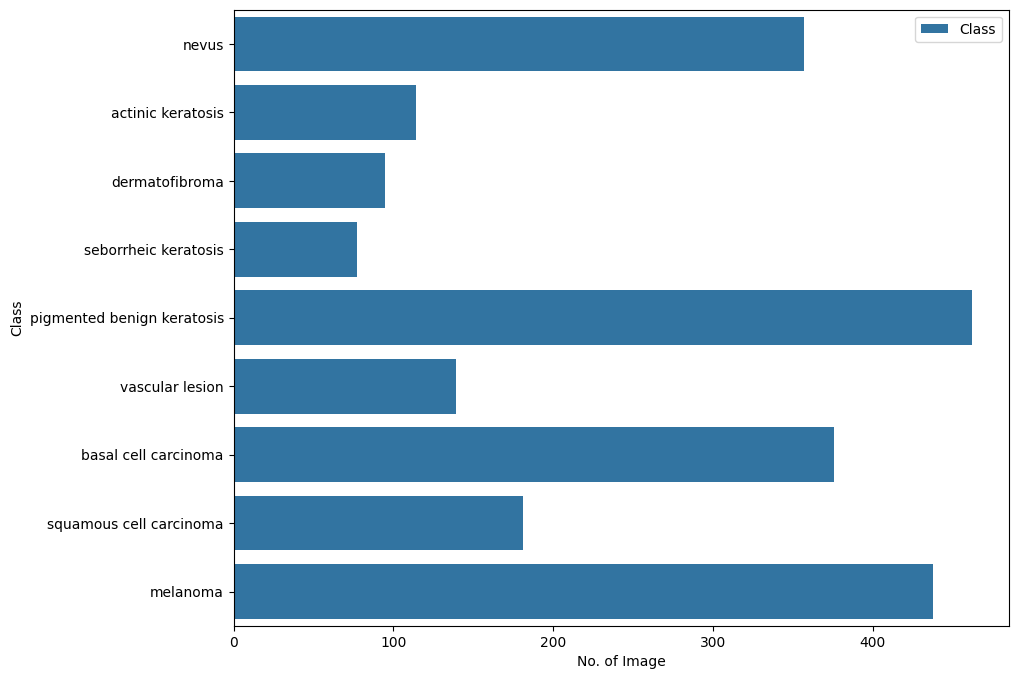

In [50]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")


- seborrheic keratosis has the least number of samples only 77.

- pigmented benign keratosis (462 Samples), melanoma (438 Samples), basal cell carcinoma (376 Samples), and nevus (357 Samples) classes dominates the data in terms proportionate number of samples .


####  Rectify the class imbalance
#### Use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [51]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [53]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BE030336990>: 100%|██████████| 500/500 [00:15<00:00, 31.60 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BE031E5F790>: 100%|██████████| 500/500 [00:18<00:00, 26.50 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BE031D77450>: 100%|██████████| 500/500 [00:15<00:00, 31.35 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BE0BC108A50>: 100%|██████████| 500/500 [01:16<00:00,  6.51 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7BE0BC0DB690>: 100%|██████████| 500/500 [01:08<00:00,  7.34 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BE0303E4250>: 100%|██████████| 500/500 [00:14<00:00, 34.09 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BE0307C0F90>: 100%|██████████| 500/500 [00:38<00:00, 13.07 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BE04049AF90>: 100%|██████████| 500/500 [00:14<00:00, 34.86 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BE03031DAD0>: 100%|██████████| 500/500 [00:14<00:00, 34.31 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [56]:
# Count total number of image generated by Augmentor.
# Convert data_dir_train back to a pathlib.Path object
data_dir_train = pathlib.Path(data_dir_train)
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


### see the distribution of augmented data after adding new images to the original training data.

In [57]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [58]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [59]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [60]:
#dataframe that store path and label of the images generated by Augmentor
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [61]:
#label count.
df2['Label'].value_counts()

,count
Label,
nevus,1500
actinic keratosis,1500
dermatofibroma,1500
seborrheic keratosis,1500
pigmented benign keratosis,1500
vascular lesion,1500
basal cell carcinoma,1500
squamous cell carcinoma,1500
melanoma,1500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####  Train the model on the data created using Augmentor

In [62]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [63]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

#Training dataset.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,    #20% fraction of data to reserve for validation.
  subset = "training",
  image_size=(img_height, img_width),label_mode='categorical',  #label_mode='categorical' means that the labels are encoded as a categorical vector
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


#### Create a validation dataset

In [ ]:
#Validation dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),label_mode='categorical',   #label_mode='categorical' means that the labels are encoded as a categorical vector
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create model

In [64]:
#Model

model3 = Sequential()

model3.add(rescale)   #Rescaling Layer

#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(512,activation='relu'))

#Dropout layer
model3.add(layers.Dropout(0.25))

#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization
#of the layers' inputs by re-centering and re-scaling.
model3.add(layers.BatchNormalization())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.50))

#Batch normalization
model3.add(layers.BatchNormalization())

#Dense layer with Softmax activation function.
model3.add(layers.Dense(len(class_names),activation='softmax'))

#### Compile Model

In [65]:

model3.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])


####  Train your model

In [ ]:
epochs = 50
history = model3.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 55s 124ms/step - accuracy: 0.1810 - loss: 2.4624 - val_accuracy: 0.2806 - val_loss: 2.3694
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - accuracy: 0.3986 - loss: 1.5712 - val_accuracy: 0.3846 - val_loss: 1.5389
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - accuracy: 0.4843 - loss: 1.3727 - val_accuracy: 0.4684 - val_loss: 1.3753
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 46s 113ms/step - accuracy: 0.5366 - loss: 1.2320 - val_accuracy: 0.5791 - val_loss: 1.1537
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.5693 - loss: 1.1656 - val_accuracy: 0.5041 - val_loss: 1.2336
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.6012 - loss: 1.0689 - val_accuracy: 0.6652 - val_loss: 0.9202
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.6652 - loss: 0.9185 - val_accuracy: 0.6682 - val_loss: 0.8736
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - accuracy: 0.6817 - loss: 0

####  Visualize the model results

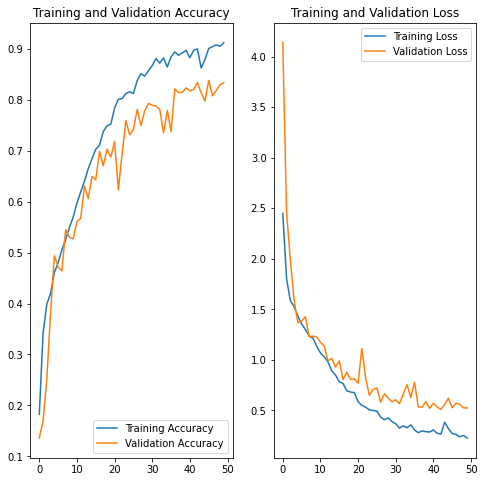

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 -  As per the final model (model3) Training accuracy and validation accuracy increases.
 -  Model overfitting issue is solved.
 -  Class rebalance helps in augmentation and achieving the best Training and validation accuracy.